<a href="https://colab.research.google.com/github/Raghuram-Veeramallu/Astro_Stat_Project2/blob/development/Project2_Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AST/STAT 5731 Project 2
## Research Synopsis
**Group 3**   
Daniel Warshofsky  
Hari Veeramallu  
Jacynda Alatoma  
Nicholas Kruegler

### Research Question

What is the value of Hubble's constant as found from a linear regression of the redshifts and distances of Type Ia supernovae within a redshift of 0.1?

In [ ]:
# load data for this instance
!gdown 1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0

Downloading...
From: https://drive.google.com/uc?id=1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0
To: /content/snaeT1.tsv
100% 47.4k/47.4k [00:00<00:00, 33.7MB/s]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
## setting the theme for the grid
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [4]:
df = pd.read_csv('/content/snaeT1.tsv',sep='\t')

In [4]:
df.describe()

,zcmb,zhel,mb,e_mb,x1,e_x1,c,e_c,logMst
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,0.323870,0.324449,20.904961,0.115899,0.036589,0.311096,-0.023878,0.038897,9.795342
std,0.276893,0.276748,2.655139,0.018767,0.988554,0.211399,0.084118,0.015694,1.395068
min,0.010000,0.009400,14.148000,0.085000,-2.863000,0.018000,-0.250000,0.012000,5.000000
25%,0.124000,0.124425,19.735500,0.102000,-0.650250,0.148500,-0.084250,0.026000,9.316750
50%,0.229000,0.230500,21.099000,0.114000,0.165500,0.268000,-0.030500,0.035000,10.193500
75%,0.498000,0.499000,23.043000,0.124000,0.775750,0.420000,0.031000,0.050000,10.710250
max,1.299000,1.300000,26.047000,0.175000,2.337000,1.641000,0.260000,0.107000,11.817000


**Column Description:**.

| Column  | Description                 |
| ------- | --------------------------- |
| zcmb    | CMB Frame Redshift          |
| zhel    | Heliocentric Redshift       |
| mb      | B band peak magnitude (in mB)|
| e_mb    | Error in mb                 |
| x1      | SALT2 shape (stretch) parameter |
| e_x1    | Error in x1                 |
| c       | SALT2 color parameter       |
| e_c     | Error in c                  |
| logMst  | $Log_{10}$ Host Stellar Mass|

### **Processing Data**

Since we want to estimate the relationship between the Distance and the Redshift (CMB), we need to compute the distance from the parameters that we have available to us.

Distance can be computed through Distance Modulii $\mu$, defined as
$$ \mu = m_{B}^{*} - (M_{B} - \alpha X_{1} + \beta C)$$
where,  
$m_{B}^{*}$ is the observed peak magnitude in rest frame B band.  
$M_{B}$ is the absolute magnitude of the supernova (adjusted based on host galaxy's properties). It depends on the host galalxy's stellar mass ($M_{stellar}$).   
$$M_{B} = \begin{cases} M_{B}^{1} & \text{if $M_{stellar} < 10^{10} M_{\odot}$} \\
M_{B}^{1} + \Delta_{m} & \text{otherwise}
\end{cases}$$   
here, $M_{\odot}$ is the mass of the Sun.   
$\alpha, \beta$ are the nuisance parameters that account for the shape of the light curve ($X_{1}$) and the color of the supernova ($C$) respectively.  
$\beta, M_{B}$ are found to be dependent on the host galaxy properties.  

Modulus can be converted into distance (in parsec) using $ d_{L} = 10^{\mu/5 + 1} $.

($\mu = 5 log_{10}{(d_{L} /10 \,\mathrm{pc})}$ according to the literature[[1](https://www.aanda.org/articles/aa/pdf/2014/08/aa23413-14.pdf)]).

Since there are errors associated with each measurement, we need to estimate the distance errors as well.   

Error parameter $\sigma_{\mu}$ = $\sqrt{\sigma_{m_{b}}^{2} + (\alpha \sigma_{X_{1}})^2 + (\beta \sigma_{C})^2}$.  
where $\sigma_{m_{b}}, \sigma_{X_{1}}, \sigma_{C}$ refer to the error terms of $m_{b}, X_{1}$ and $C$ (`e_mb`, `e_x1` and `e_c` from the dataset).  

From the literature the values used are, $\alpha = 0.141, \beta = 3.101, M_{B}^{1} = -19.05$ and $\Delta_{M} = -0.07$ (according to the C11 analysis)

In [5]:
# defining the nuisance parameters
alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

#picking out data within z=0.1
data = df[df["zcmb"]<0.1].copy()

# MB
data['MB'] = MB1 + (DeltaM * (data['logMst'] > 10))

# mu
data['dist_moduli'] = data['mb'] - (data['MB'] - alpha * data['x1'] + beta * data['c'])

# distance
data['d'] = 10 ** (data['dist_moduli']/5 + 1) * 10**(-6) #converting to Mpc

# distance modulii (mu) error
data['e_mu'] = np.sqrt(data['e_mb'] ** 2 + (alpha * data['e_x1']) ** 2 + (beta * data['e_c']) ** 2)

# distance error
data['e_d']= (data['e_mu'] * np.log(10) * np.abs(data['d']))/5

In [ ]:
#summary of the z<0.1 data
data.describe()

,zcmb,zhel,mb,e_mb,x1,e_x1,c,e_c,logMst,MB,dist_moduli,d,e_mu,e_d
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.038625,0.038677,16.704684,0.139704,-0.322553,0.134072,0.000250,0.026868,10.247789,-19.103882,35.762311,173.772068,0.165633,12.900848
std,0.023841,0.024271,1.375018,0.015207,1.095961,0.103282,0.081259,0.008219,1.066666,0.029568,1.387712,112.813504,0.021707,8.102604
min,0.010000,0.009400,14.148000,0.110000,-2.863000,0.018000,-0.146000,0.012000,5.000000,-19.120000,33.074674,41.203566,0.117129,3.660614
25%,0.020750,0.020175,15.738000,0.139000,-1.173500,0.069000,-0.055000,0.022000,10.055750,-19.120000,34.756614,89.396983,0.155352,6.914101
50%,0.030000,0.030350,16.645500,0.142000,-0.246500,0.108000,-0.017000,0.025000,10.525500,-19.120000,35.692523,137.566100,0.166288,10.272835
75%,0.055000,0.054650,17.807500,0.148000,0.605500,0.175250,0.057750,0.029000,10.842250,-19.120000,36.930773,243.322508,0.173122,18.082868
max,0.096000,0.097000,19.773000,0.175000,2.022000,0.782000,0.229000,0.058000,11.381000,-19.050000,38.402242,479.124523,0.244960,35.027986


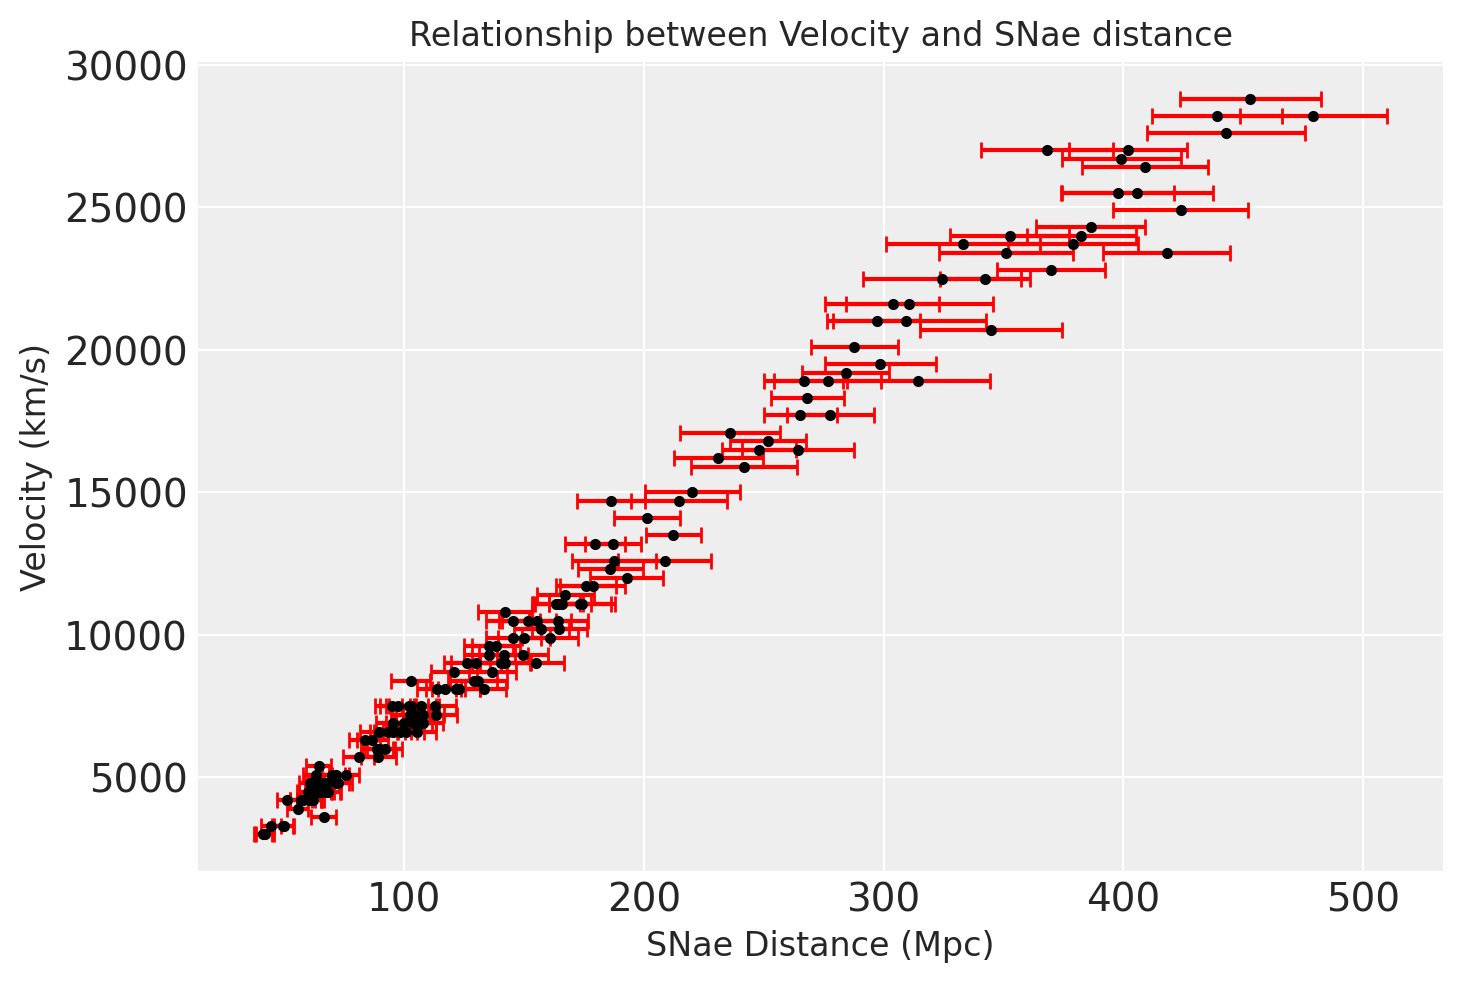

In [182]:
plt.errorbar( data['d'],data['zcmb']*(3e5),xerr=data['e_d'],fmt="k.",ecolor="r",capsize=3)
plt.ylabel('Velocity (km/s)', size=12)
plt.xlabel('SNae Distance (Mpc)', size=12)
plt.title('Relationship between Velocity and SNae distance', size=12)
plt.show()

### **Statistical Model**  

1. $x$, the redshift of the SNae
2. $X=(0,0.1]$, the set of all redshift values less than 0.1
3. Observed distance (in Mpc), $y=[41.2,479.1]$ (i.e. the given data)
4. Sample space, $Y = \mathbb{R}_+^{n}$  
5. The likelihood for our normal regression is $$Y|X,\beta,\tau \sim N(x_i\beta,\tau^{-1})$$
where $x_i\beta$ is the linear regression model $x_i\beta = H_0 d$, the response $Y=cz$ is the speed of light $c$ times the redshift $z$, the distance $d$ is $d=10^{\mu/5-1}$, and the modulus is $\mu = m_{B}^{*} - (M_{B} - \alpha X_{1} + \beta C)$.

6. The priors for our model parameters are defined as
$$H_0 \sim N(0,1000)$$
$$m_B \sim N(0,1000)$$
$$X_1 \sim N(0,1000)$$
$$C \sim N(0,1000)$$
$$\tau \sim \mathrm{Gamma}(1,1)$$
which involve standard weakly informative choices for the hyperparameters of the normal and gamma distributions.
Each of these priors (call them $\Psi$), excluding $\tau$ and $H_0$, have observed values, $\Psi^*$, that are determined from measurement error with the general form
$$\Psi^* \sim N(\Psi,\sigma_{\psi}^2)$$

In [6]:
#full model
z = data["zcmb"]
velocity = z*(3e5)
dist_mod = data["dist_moduli"]
dist_mod_err = data["e_mu"]

alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

with pm.Model() as model:
    #Define data
    x=pm.MutableData('x',data['x1'])
    c=pm.MutableData('c',data['c'])
    mb=pm.MutableData('mb',data['mb'])
    MB=pm.MutableData('MB',data['MB'])

    #define H0
    H0 = pm.Normal("H0",mu=0,tau=1/1000)
    p = pm.Gamma('precision', alpha=1, beta=1)

    X = pm.Normal("X",mu=0,tau=1/1000)
    X_obs = pm.Normal("X_obs",mu=X,tau=1/data['e_x1']**2,observed=x,shape=len(data['x1']))

    C = pm.Normal("C",mu=0,tau=1/1000)
    C_obs = pm.Normal("C_obs",mu=C,tau=1/data['e_c']**2,observed=c,shape=len(data['c']))

    m = pm.Normal("m",mu=0,tau=1/1000)
    m_obs = pm.Normal('m_obs',mu=m,tau=1/data['e_mb']**2,observed=mb,shape=len(data['mb']))

    #define modulus model with measurement error
    distance_mod = pm.Deterministic("distance_mod", m - (MB - alpha * X + beta * C))
    distance = pm.Deterministic("distance",10**(distance_mod/5-5))   # -5 to account for conversion from Pc to MPc

    #define response
    Y = pm.Normal("velocity",mu=H0*distance,tau=p,observed=velocity)

    # adding this for prior a posterior predictive checks
    idata = pm.sample_prior_predictive(samples=50, random_seed=5731)

Sampling: [C, C_obs, H0, X, X_obs, m, m_obs, precision, velocity]


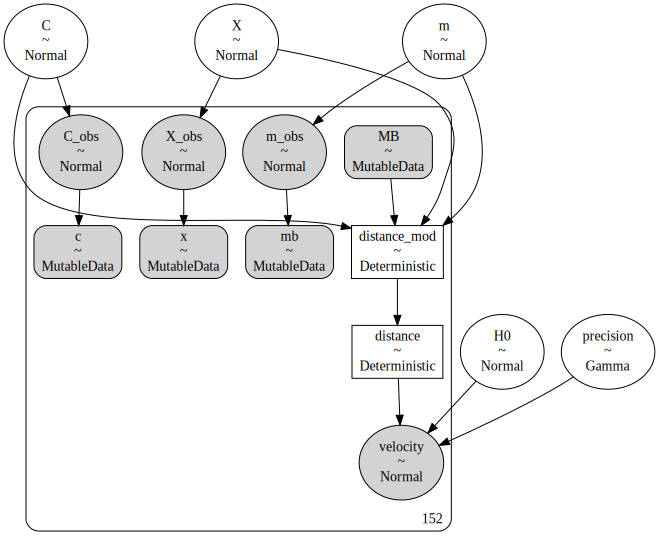

In [ ]:
pm.model_to_graphviz(model)

In [7]:
#find minimum sample size
from scipy.stats import chi2
from scipy.special import gamma

def minESS(p,alpha=0.05,epsilon=0.05):
    X2=chi2.ppf(1-alpha, p)
    min_num=np.rint(np.pi*(2./p/gamma(p/2))**(2/p)*X2/epsilon**2)
    return min_num.astype(int)

#one parameters of beta so we have 3 degrees of freedom
N_sample = minESS(3).astype(int)

print('Minimum effective size:', N_sample)

Minimum effective size: 8123


In [ ]:
with model:
  trace = pm.sample(9000)

array([[<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>]],
      dtype=object)

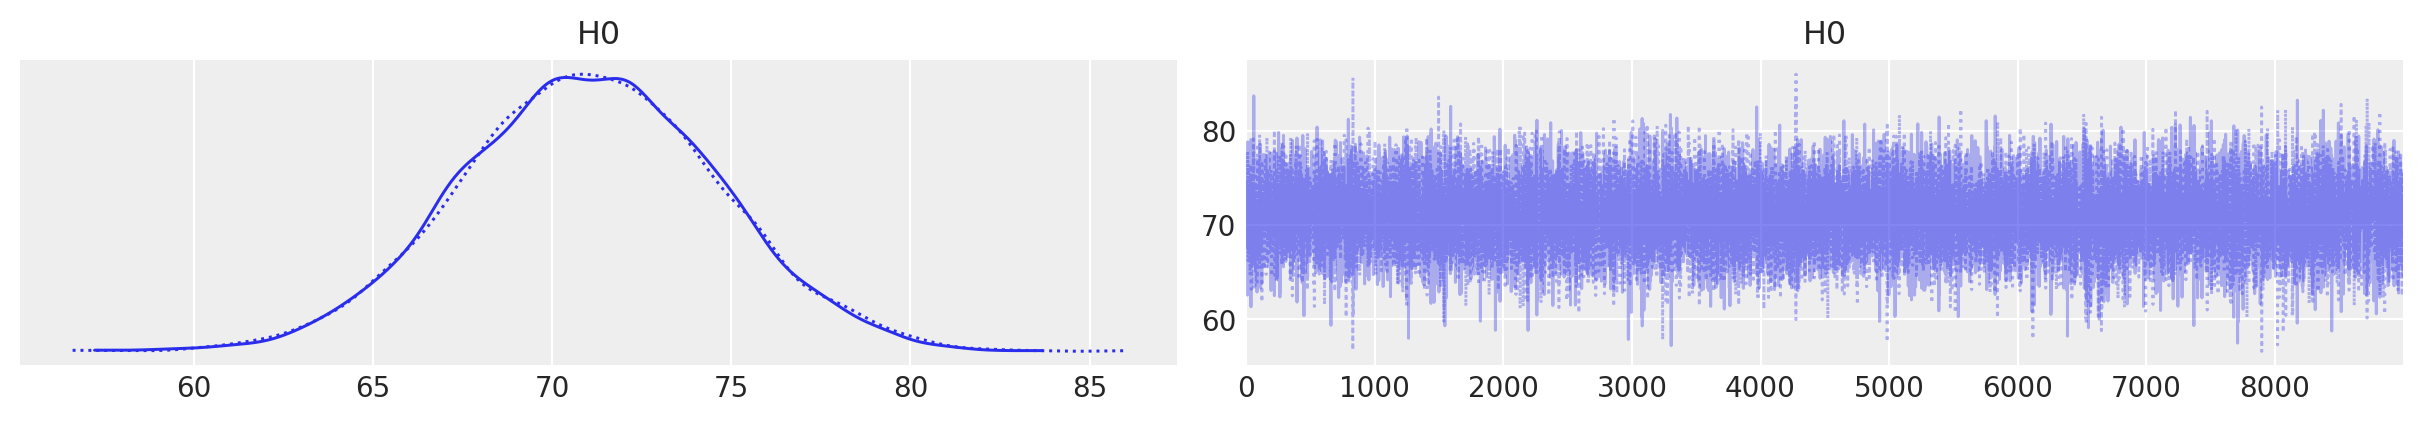

In [ ]:
az.plot_trace(trace,var_names=["H0"])

In [ ]:
az.summary(trace,var_names=["H0"],round_to=3,hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H0,71.033,3.602,64.108,78.237,0.02,0.014,33941.729,15118.675,1.0


<Axes: title={'center': 'H0'}>

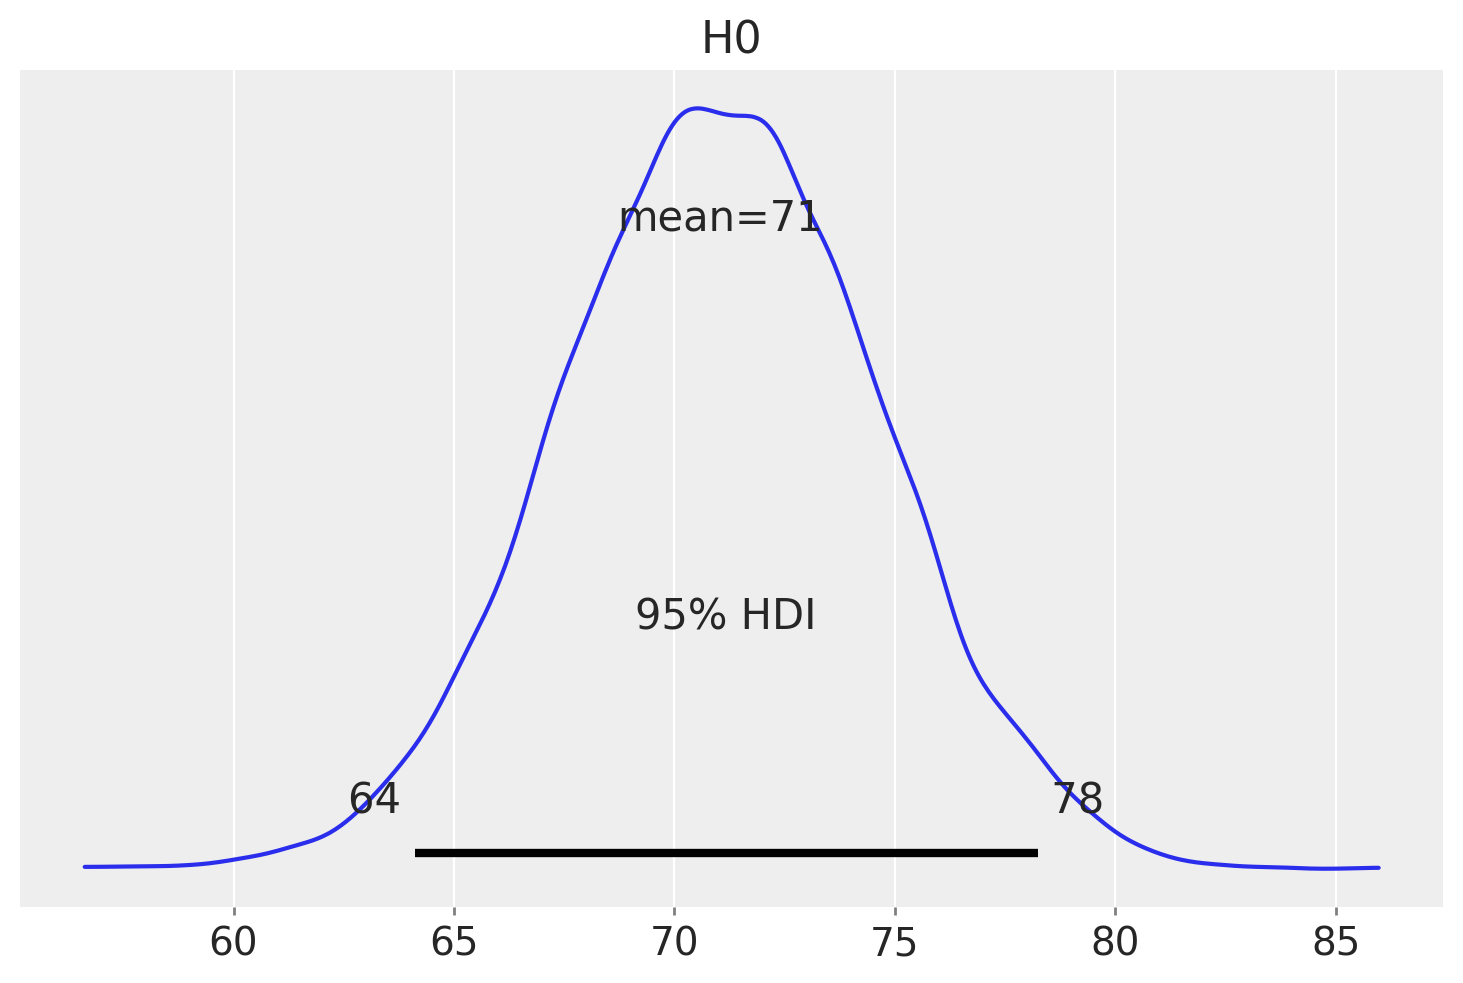

In [ ]:
az.plot_posterior(trace,var_names=["H0"],hdi_prob=0.95)

In [ ]:
n=1000
samp = trace.posterior.sel(chain=np.random.choice(range(0,2),size=n),
                                  draw=np.random.choice(range(0,9000),size=n,replace=False))
samp=np.array([samp['H0'][0]])

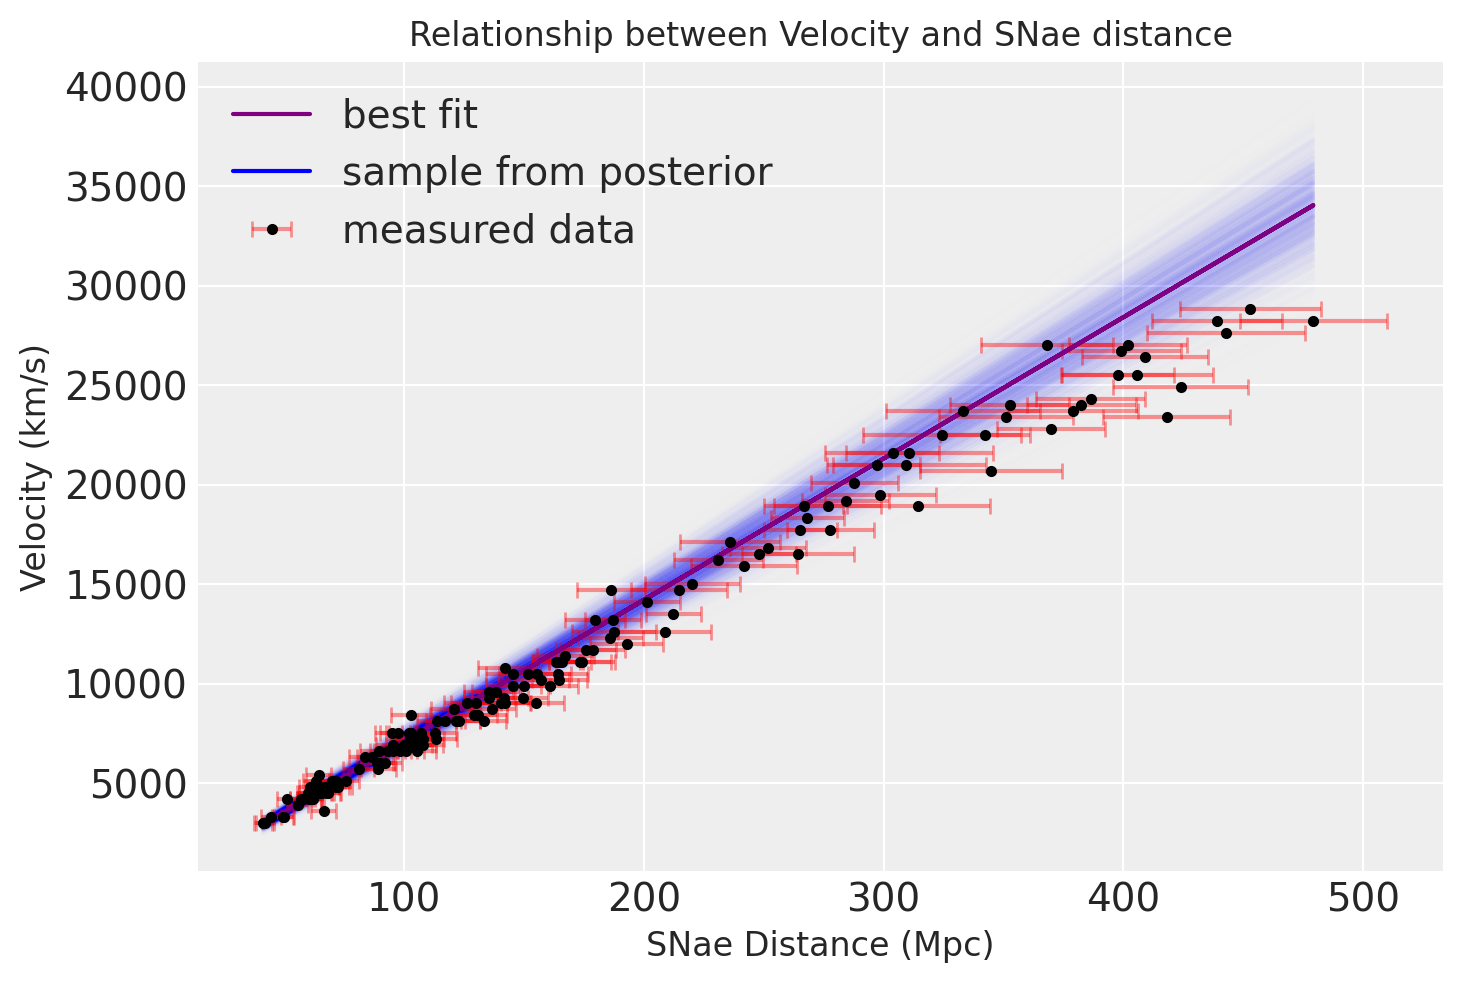

In [ ]:
fig,ax=plt.subplots()

ax.errorbar(data['d'],3e5*data['zcmb'],xerr=data['e_d'],fmt="k.",ecolor=[1,0,0,0.4],capsize=3,zorder=2,label="measured data")
ax.set_ylabel('Velocity (km/s)', size=12)
ax.set_xlabel('SNae Distance (Mpc)', size=12)
ax.set_title('Relationship between Velocity and SNae distance', size=12)

H0_mean = az.summary(trace,var_names=["H0"],round_to=3,hdi_prob=0.95)["mean"].values[0]
ax.plot(data["d"],H0_mean*data["d"],color="purple",label="best fit")

#only present to get axis label there (will be hidden under other parts)
ax.plot(data["d"],H0_mean*data["d"],color="blue",label="sample from posterior",zorder=0)

for H0 in samp.T:
    ax.plot(data["d"],H0*data["d"],alpha=0.005,color='blue',zorder=1)

plt.legend()

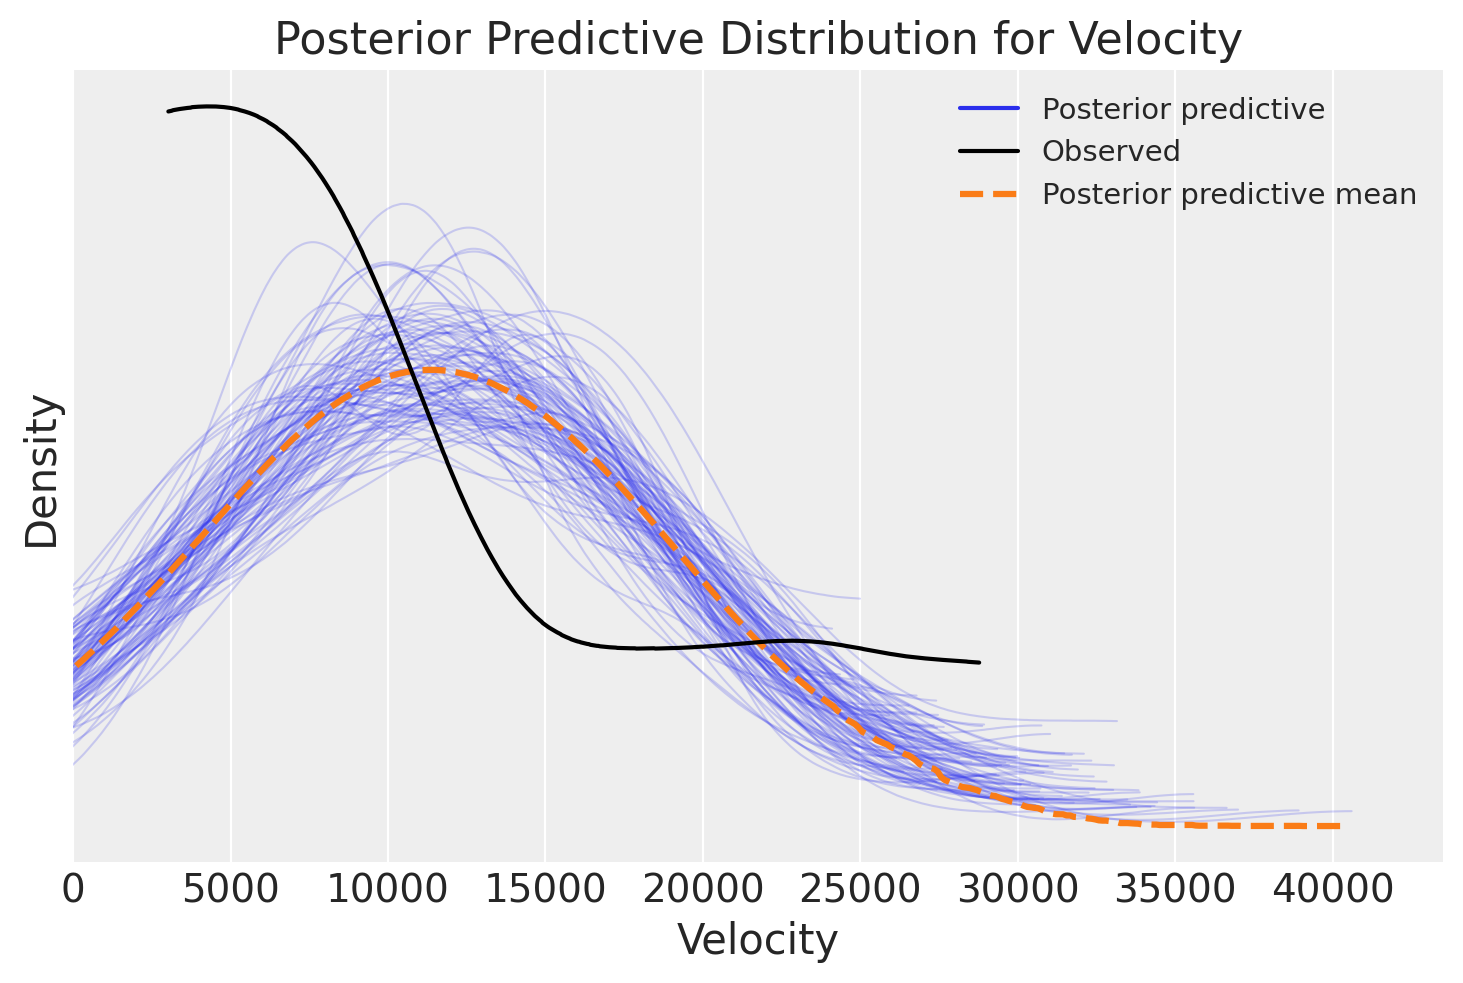

In [ ]:
# Posterior Predictive
with model:
    idata.extend(pm.sample(1000, tune=2000, random_seed=5731))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=5731)

az.plot_ppc(idata, var_names = ['velocity'], num_pp_samples=100);
plt.xlabel('Velocity')
plt.ylabel('Density')
plt.title('Posterior Predictive Distribution for Velocity')
plt.xlim(0, None)
plt.show()

Sampling: [C, C_obs, H0, X, X_obs, m, m_obs, obs, precision, sigma]


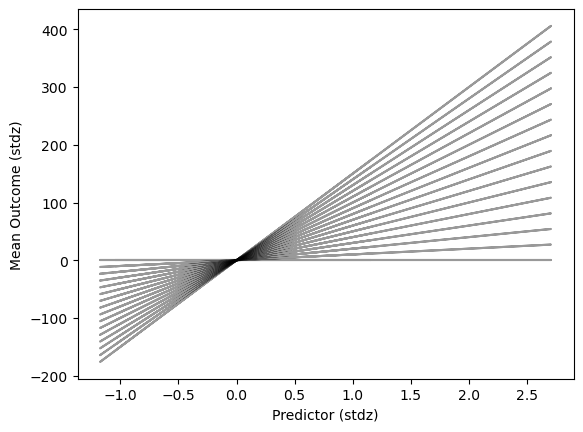

In [8]:
import xarray as xr

# standardizing variables just for the sake of axis scales
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

predictor_scaled = standardize(data['d'])

z = data["zcmb"]
velocity = z*(3e5)
outcome_scaled = standardize(velocity)
dist_mod = data["dist_moduli"]
dist_mod_err = data["e_mu"]

alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

# Re-reunning model with standardized variables
with pm.Model() as model:
    #Define data
    x=pm.MutableData('x',data['x1'])
    c=pm.MutableData('c',data['c'])
    mb=pm.MutableData('mb',data['mb'])
    MB=pm.MutableData('MB',data['MB'])

    #define H0
    H0 = pm.Normal("H0",mu=0,tau=1/1000)
    p= pm.Gamma('precision', alpha=1, beta=1)

    X = pm.Normal("X",mu=0,tau=1/1000)
    X_obs = pm.Normal("X_obs",mu=X,tau=1/data['e_x1']**2,observed=x,shape=len(data['x1']))
    C = pm.Normal("C",mu=0,tau=1/1000)
    C_obs = pm.Normal("C_obs",mu=C,tau=1/data['e_c']**2,observed=c,shape=len(data['c']))

    m = pm.Normal("m",mu=0,tau=1/1000)
    m_obs = pm.Normal('m_obs',mu=m,tau=1/data['e_mb']**2,observed=mb,shape=len(data['mb']))

    #define modulus model with measurement error
    distance_mod = pm.Deterministic("distance_mod", m - (MB - alpha * X + beta * C))
    distance = pm.Deterministic("distance",10**(distance_mod/5-5))   #+7 to account for conversion from Pc to MPc

    # This is calculating our Y
    Y = distance * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)
    pm.Normal("obs", mu=Y, sigma=sigma, observed=outcome_scaled)

    # adding this for prior a posterior predictive checks
    idata = pm.sample_prior_predictive(samples=50, random_seed=5731)
    

# predicting on the prior data

x = xr.DataArray(predictor_scaled)
prior = idata.prior
y = prior["distance_dim_0"] * x

# sub-sampling every 10 to make it easier to see on the graph bc lots of data points
subsampled_y = y[::10]

_, ax = plt.subplots()

# Convert x and y to numpy arrays for plotting
x_values = x.values
y_values = y.values

# Plotting the predictive check
ax.plot(x_values, subsampled_y.T, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
plt.show()